In [1]:
# Ajouter le dossier `src` au chemin de recherche Python
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Importer la fonction `load_data` depuis le module `preprocess` dans `data_processing`
from data_processing.preprocessing import *
from utils.plotting import *
from tests_statistics.moments import *
from tests_statistics.jarque_bera import jarque_bera_test

# Spécifier le chemin vers le fichier de données
filepath = '../data/raw/out12.csv'

# Charger les données
data = load_data(filepath)

Aperçu des données chargées :
   day      tick  logprice
0    1  0.002436  4.169607
1    1  0.002479  4.168214
2    1  0.002564  4.168214
3    1  0.003034  4.168214
4    1  0.003590  4.168524


In [2]:
# Vérifier les valeurs manquantes
check_missing_values(data)

Valeurs manquantes par colonne :
Series([], dtype: int64)


day         0
tick        0
logprice    0
dtype: int64

In [3]:
# Calcul des price 
price(data, log_price = 'logprice', return_column = 'Price')
data.head()

,day,tick,logprice,Price
0,1,0.002436,4.169607,64.69
1,1,0.002479,4.168214,64.60
2,1,0.002564,4.168214,64.60
3,1,0.003034,4.168214,64.60
4,1,0.003590,4.168524,64.62


In [4]:
# Calcul du simple return 
simple_return(data, price_column = 'Price', return_column = 'simple_return')
data.head()

,day,tick,logprice,Price,simple_return
0,1,0.002436,4.169607,64.69,NaN
1,1,0.002479,4.168214,64.60,-0.001391
2,1,0.002564,4.168214,64.60,0.000000
3,1,0.003034,4.168214,64.60,0.000000
4,1,0.003590,4.168524,64.62,0.000310


In [5]:
# Calcul du compounded return 
compounded_return(data, log_price_column = 'logprice', return_column = 'compounded_return')
data.head()

,day,tick,logprice,Price,simple_return,compounded_return
0,1,0.002436,4.169607,64.69,NaN,NaN
1,1,0.002479,4.168214,64.60,-0.001391,-0.001392
2,1,0.002564,4.168214,64.60,0.000000,0.000000
3,1,0.003034,4.168214,64.60,0.000000,0.000000
4,1,0.003590,4.168524,64.62,0.000310,0.000310


In [6]:
# Supprimer la première ligne
data = data.dropna()
data.head()

,day,tick,logprice,Price,simple_return,compounded_return
1,1,0.002479,4.168214,64.60,-0.001391,-0.001392
2,1,0.002564,4.168214,64.60,0.000000,0.000000
3,1,0.003034,4.168214,64.60,0.000000,0.000000
4,1,0.003590,4.168524,64.62,0.000310,0.000310
5,1,0.003675,4.168060,64.59,-0.000464,-0.000464


In [7]:
print(data['compounded_return'].describe())

count    1.615410e+06
mean    -1.364727e-06
std      7.446338e-04
min     -1.762480e-01
25%     -2.584313e-04
50%      0.000000e+00
75%      2.571686e-04
max      1.166369e-01
Name: compounded_return, dtype: float64


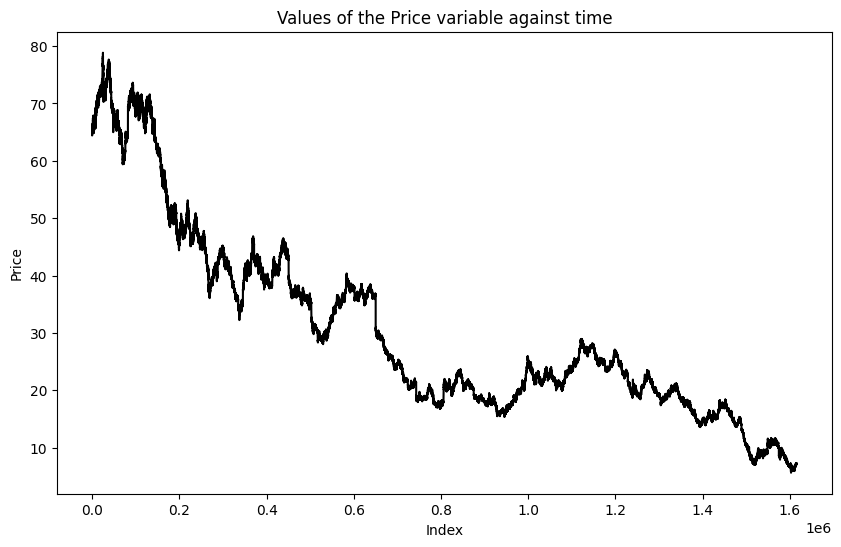

In [8]:
plot_price(data, return_column = 'Price')

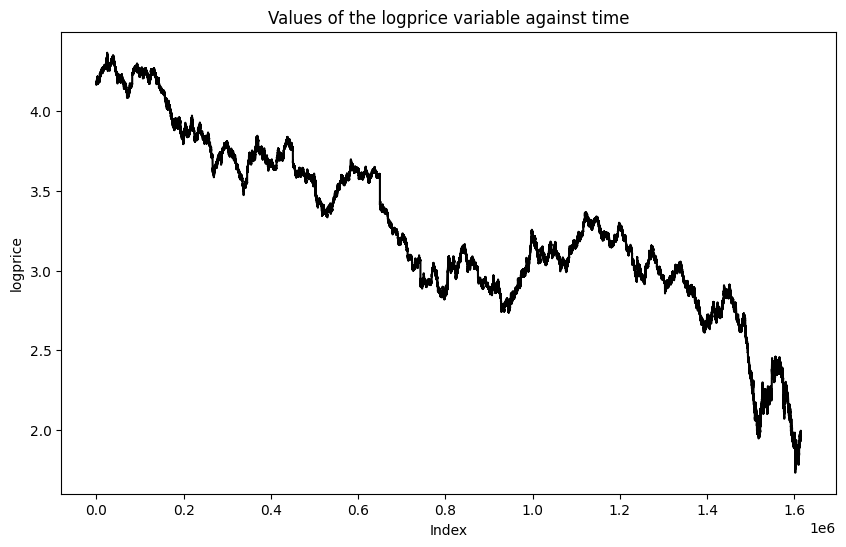

In [9]:
plot_price(data, return_column = 'logprice')

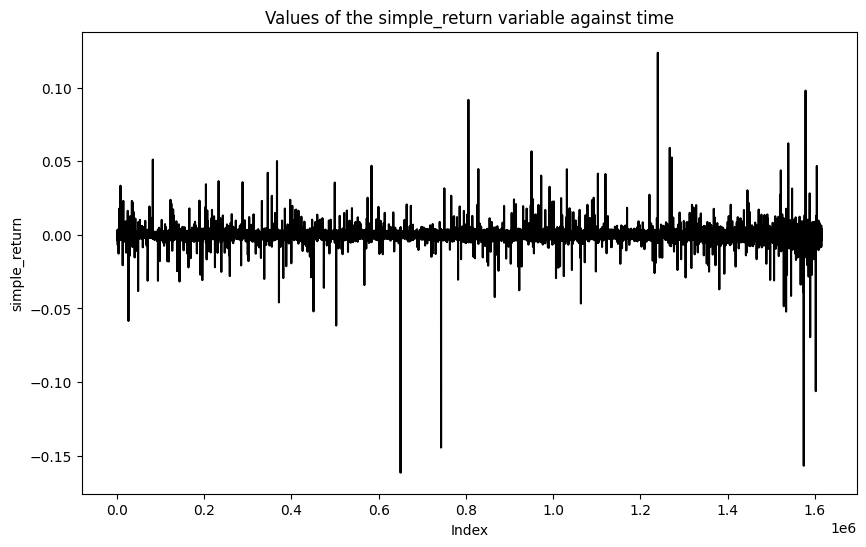

In [10]:
plot_return(data, return_column = 'simple_return')

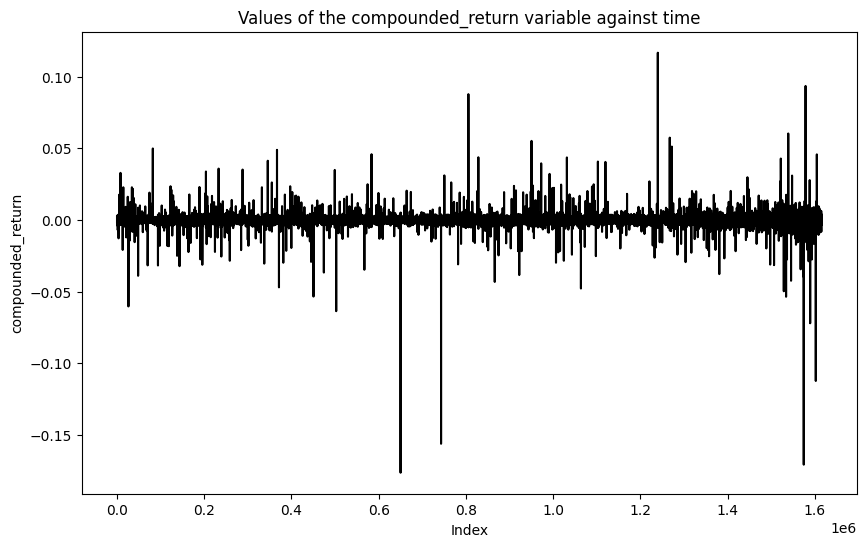

In [11]:
plot_return(data, return_column = 'compounded_return')

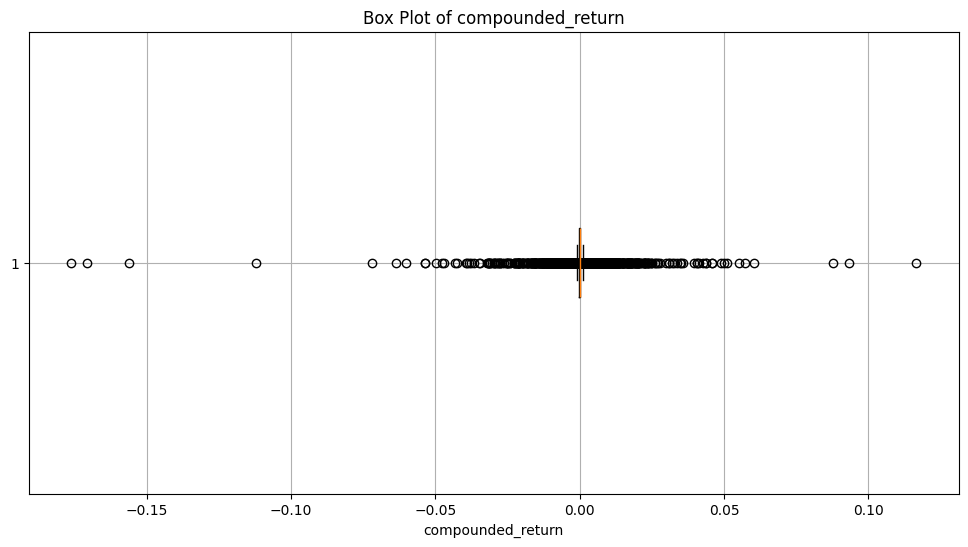

In [12]:
plot_boxplot(data, column = 'compounded_return')

In [13]:
# Calcul des statistiques
mean_value = empirical_mean(data, 'compounded_return')
variance_value = empirical_variance(data, 'compounded_return')
skewness_value = empirical_skewness(data, 'compounded_return')
kurtosis_value = empirical_kurtosis(data, 'compounded_return')

# Affichage des résultats
print(f"Empirical Mean: {mean_value}")
print(f"Empirical Variance: {variance_value}")
print(f"Empirical Skewness: {skewness_value}")
print(f"Empirical Kurtosis: {kurtosis_value}")


Empirical Mean: -1.364727455647231e-06
Empirical Variance: 5.544791283286485e-07
Empirical Skewness: -19.382784699148104
Empirical Kurtosis: 6307.563527054117


### Assumption of Data Frequency:
**Time Interval:**

To estimate the time interval between observations, we can divide the total duration of a trading day by the total number of observations. For example, a typical trading day in many markets lasts about 6.5 hours (e.g., from 9:30 AM to 4:00 PM in U.S. markets), which translates to 23,400 seconds.

Thus, the average time interval between observations can be calculated as:

$$
\Delta_t = \frac{23400 \text{ s}}{1638 \text{ obs}} \approx 14.3 \text{ s}
$$

This narrow time interval results in a mean of returns that is very close to zero and a relatively low variance. This low variance makes the returns particularly sensitive to extreme values, which can significantly influence the distributional measures.

Therefore, we will apply a filtering process to our dataset to remove outliers and mitigate this sensitivity to extreme values.

In [14]:
# Filtrage des valeurs aberrantes dans la colonne 'compounded_return'
filtered_data = filter_outliers(data, column='compounded_return', std_dev_threshold=5)

In [15]:
mean_value = empirical_mean(filtered_data, 'compounded_return')
variance_value = empirical_variance(filtered_data, 'compounded_return')
skewness_value = empirical_skewness(filtered_data, 'compounded_return')
kurtosis_value = empirical_kurtosis(filtered_data, 'compounded_return')

print(f"Empirical Mean (filtered): {mean_value}")
print(f"Empirical Variance (filtered): {variance_value}")
print(f"Empirical Skewness (filtered): {skewness_value}")
print(f"Empirical Kurtosis (filtered): {kurtosis_value}")

Empirical Mean (filtered): -1.4526446043951077e-06
Empirical Variance (filtered): 3.216888597284468e-07
Empirical Skewness (filtered): -0.025420302332530825
Empirical Kurtosis (filtered): 8.371877016767817


These filtered results provide a more robust representation of the compounded_return distribution. The near-zero skewness and high kurtosis confirm that, while the data is generally symmetric, it still exhibits "fat tails," reflecting the presence of rare, significant deviations that are typical in high-frequency financial data. This underscores the importance of accounting for tail risk in financial models, as extreme events remain a key characteristic of the return distribution.

### Jarque-Bera Normality Test

Normality test : 
$$
H_0 : Normal dist., \quad H1 :different from Normal dist. 
$$
Under $H_0, \hat{Skew}, \hat{Kurt}$ are independent and asymptotically normal :
$$
\sqrt{n} \hat{Skew} \rightarrow_d \mathcal{N}(0,6), \quad \sqrt{n} \hat{Kurt}-3  \rightarrow_d \mathcal{N}(0,24)
$$

Jarque-Bera test statistic : Under $H_0$ as $n\rightarrow \infty$,
$$
JB = n \left(\frac{\hat{Skew}^2}{6}+ \frac{(\hat{Kurt}-3)^2}{24}\right)\rightarrow_d \chi^2(2)
$$

In [16]:
# Effectuer le test de Jarque-Bera sur la colonne 'compounded_return'
jb_results = jarque_bera_test(filtered_data, 'compounded_return')

# Afficher les résultats du test
print("Jarque-Bera Test Results:")
print(f"JB Statistic: {jb_results['JB Statistic']}")
print(f"p-value: {jb_results['p-value']}")
print(f"Normality: {jb_results['Normality']}")

Jarque-Bera Test Results:
JB Statistic: 1938560.2385356498
p-value: 0.0
Normality: Rejected


## Volatility

We call daily volatility of the asset, the standard deviation of the log-returns. 

If we observe price on T days, then we can estimate $\sigma_d$ by the square root of the empirical variance. 
$$
\sigma_d^2=\frac{1}{T} \sum_{i=1}^T R_t^2-(\bar R_t)^2
$$
where $\bar R_t = \frac{1}{T} \sum_{i=1}^T R_t$

In [17]:
# Calculer les moyennes journalières des rendements
daily_mean_returns = calculate_daily_mean_returns(filtered_data, day_column='day', return_column='compounded_return')
    
# Enregistrer les moyennes journalières dans le dossier processed
daily_mean_returns.to_csv('../data/processed/daily_mean_returns.csv', index=False)

print("Daily mean returns saved to 'data/processed/daily_mean_returns.csv'.")

Daily mean returns saved to 'data/processed/daily_mean_returns.csv'.


In [18]:
daily_mean_returns.describe()

,day,daily_mean_return
count,754.000000,754.000000
mean,377.500000,-0.000002
std,217.805341,0.000015
min,1.000000,-0.000067
25%,189.250000,-0.000010
50%,377.500000,-0.000002
75%,565.750000,0.000007
max,754.000000,0.000070


In [21]:
# Calculer les volatilités journalière, mensuelle et annualisée
volatility_results = calculate_volatility(daily_mean_returns, return_column='daily_mean_return')

# Afficher les résultats de volatilité
print("Volatility Results:")
print(f"Daily Volatility: {volatility_results['daily_volatility']}")
print(f"Monthly Volatility: {volatility_results['monthly_volatility']}")
print(f"Annualized Volatility: {volatility_results['annualized_volatility']}")

Volatility Results:
Daily Volatility: 1.4582740428658463e-05
Monthly Volatility: 4.2096745560042014e-06
Annualized Volatility: 0.00023149382764822644


These volatility results indicate a relatively stable asset with low levels of fluctuation over time. For investors or analysts, such a low annualized volatility would imply lower expected risk, which may be attractive for risk-averse strategies but could also mean lower potential returns, as higher returns often accompany higher volatility. If the dataset represents high-frequency or intraday data, this stable profile suggests that external factors may have limited influence on price movement within the observed periods.

### Nonparametric estimation of the distribution function: IID

Let $x_1, \cdots, x_n$ are iid realisations of a random variable X. Then, 
$$
F_n(c) = \frac{1}{n} \sum_{i=1}^{n} I(x_i \leq c)
$$
where $I(.)$ is an indicator function. 

Let $x_{(1)}, \cdots, x_{(n)}$ be the ordered data. For a significance level of $1-\alpha$, let $m = \lfloor na \rfloor$, the largest integer smaller than or equal to $n\alpha$. Then
$$
F_n(X \leq x_{(m)}) = \frac{m}{n} \approx \alpha
$$

### Nonparametric estimation of VaR under IID

**Assumption**: Future distribution of the returns can be estimated from information in the data to the present $\Rightarrow X_t$ are IID

**We consider that the logreturn are i.i.d**

### Estimating VaR for  $\alpha \approx 0 $

- For a very small $\alpha$, too few observations above the threshold (increasing variance)
- Estimator not defined when $\alpha < \frac{1}{n}$
- Observations are often heavy-tailed

A Pareto-type model for tail of the distribution : for a low threshold $u<0$, assume 
$$
P(X<x) \approx \frac{-c}{(-x)^\gamma}, \quad c >0, \gamma >0, x<u
$$

Thickness of the tail = $\mathbb{E}[|X|^k]<\infty$ for $k<\gamma$. How to estimate the tail index $\gamma$? 

The relation (1) implies that $P(X<x|X<u)\approx (-u)^\gamma/ (-x)^\gamma \quad \text{for} x<u$

### Hill estimator of tail index $\gamma$

Assume that the Pareto model is exact. Then the conditional density is
$$
f(x|X<u)= \gamma(-u)^\gamma (-x)^{-(\gamma+1)}, \quad x<u
$$

Assume that there are $n_u$ observations below the threshold $u$. Then the MLE of $\gamma$ as 
$$
\hat\gamma = \left[\frac{1}{n_u} \sum_{i=1}^{n_u} \{log(-x_{(i)})- log(-u)\right]^{-1}
$$

Often the threshold $u$ is actually taken to be the $k$th order statistic, $X_{(k)}$, which involves the bias-variance trade-off. 

### Estimation of VaR

Estimation of c can be performed by matching the theoretical and empirical proportions: 
$$
P(X<u) = \frac{-c}{(-u)^\gamma}=\frac{m}{n}, \quad -\hat c = \frac{n_u}{n}(-u)^{\hat\gamma}
$$

Plugging into the Pareto model provides an etimate of high quantiles
$$
P(X<x_\alpha) = \frac{-c}{(-x_\alpha)^{\hat\gamma}}= \alpha
$$

The estimation of $VaR(\alpha)$ is then 
$$
\hat{VaR}(\alpha)= \hat{x_\alpha}= u \left(\frac{n_u}{n \alpha}\right)^{\frac{1}{\hat\gamma}}
$$